Model berhasil dimuat dari 'models/eye_status_model.h5'


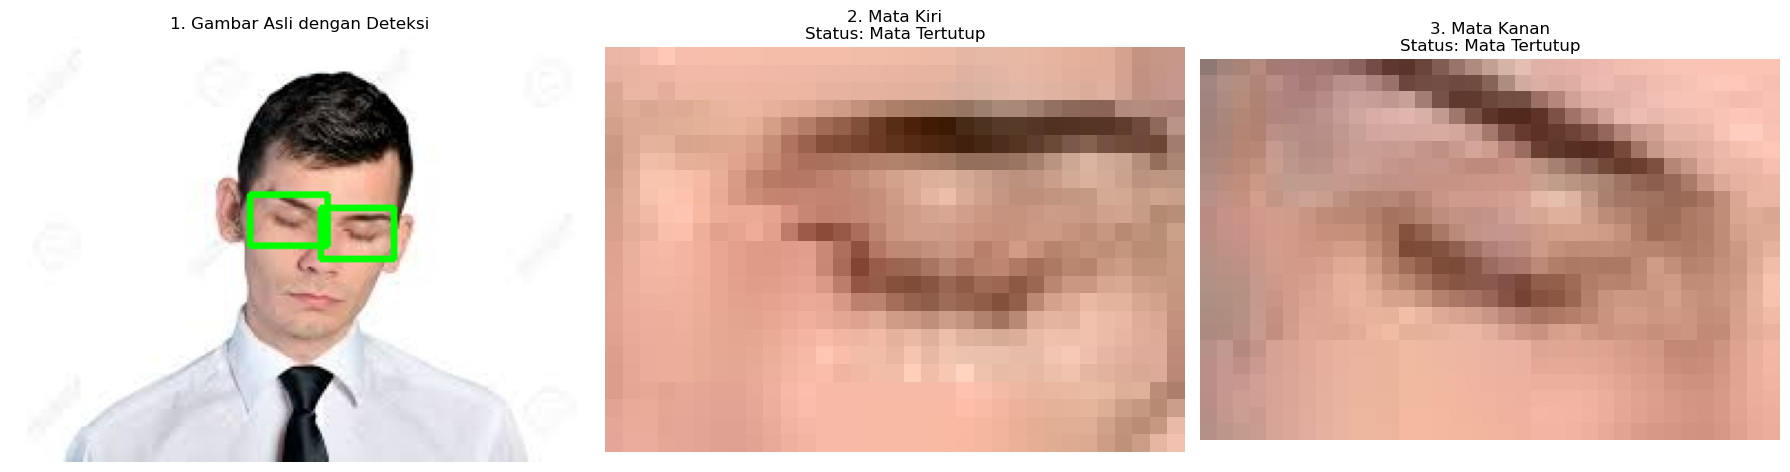

In [1]:
import cv2
import numpy as np
import mediapipe as mp
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Magic command untuk menampilkan plot matplotlib secara inline di Jupyter
%matplotlib inline

MODEL_PATH = 'models/eye_status_model.h5'
IMAGE_PATH = 'test_pict/images (1).jpeg' 

# Pengaturan Model dan MediaPipe
IMG_SIZE = 24
CLASS_LABELS = ['Mata Tertutup', 'Mata Terbuka']
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5)

# Muat model klasifikasi mata
try:
    model = load_model(MODEL_PATH)
    print(f"Model berhasil dimuat dari '{MODEL_PATH}'")
except Exception as e:
    print(f"Error saat memuat model: {e}")

# Landmark mata dari MediaPipe
LEFT_EYE_IDXS = [362, 382, 381, 380, 374, 373, 390, 249, 263, 466, 388, 387, 386, 385, 384, 398]
RIGHT_EYE_IDXS = [33, 7, 163, 144, 145, 153, 154, 155, 133, 173, 157, 158, 159, 160, 161, 246]

def predict_eye_status(eye_img):
    if eye_img is None or eye_img.size == 0:
        return "Tidak Terdeteksi", 0.0

    gray_eye = cv2.cvtColor(eye_img, cv2.COLOR_BGR2GRAY)
    resized_eye = cv2.resize(gray_eye, (IMG_SIZE, IMG_SIZE))
    normalized_eye = resized_eye / 255.0
    input_eye = np.expand_dims(np.expand_dims(normalized_eye, axis=-1), axis=0)
    
    prediction = model.predict(input_eye, verbose=0)
    probability = prediction[0][0]
    status = CLASS_LABELS[1] if probability > 0.5 else CLASS_LABELS[0]
    return status, probability

original_image = cv2.imread(IMAGE_PATH)
if original_image is not None:
    annotated_image = original_image.copy()
    h, w, _ = annotated_image.shape
    rgb_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb_image)

    left_eye_crop = None
    right_eye_crop = None

    if results.multi_face_landmarks:
        face_landmarks = results.multi_face_landmarks[0].landmark
        padding = 10

        # Proses mata kiri
        left_eye_points = np.array([[int(face_landmarks[i].x * w), int(face_landmarks[i].y * h)] for i in LEFT_EYE_IDXS])
        lx_min, ly_min = np.min(left_eye_points, axis=0)
        lx_max, ly_max = np.max(left_eye_points, axis=0)
        left_eye_crop = original_image[ly_min-padding:ly_max+padding, lx_min-padding:lx_max+padding]
        cv2.rectangle(annotated_image, (lx_min-padding, ly_min-padding), (lx_max+padding, ly_max+padding), (0, 255, 0), 2)

        # Proses mata kanan
        right_eye_points = np.array([[int(face_landmarks[i].x * w), int(face_landmarks[i].y * h)] for i in RIGHT_EYE_IDXS])
        rx_min, ry_min = np.min(right_eye_points, axis=0)
        rx_max, ry_max = np.max(right_eye_points, axis=0)
        right_eye_crop = original_image[ry_min-padding:ry_max+padding, rx_min-padding:rx_max+padding]
        cv2.rectangle(annotated_image, (rx_min-padding, ry_min-padding), (rx_max+padding, ry_max+padding), (0, 255, 0), 2)
    
    # Lakukan prediksi
    left_eye_status, _ = predict_eye_status(left_eye_crop)
    right_eye_status, _ = predict_eye_status(right_eye_crop)
else:
    print(f"Gagal memuat gambar dari {IMAGE_PATH}")
    left_eye_status, right_eye_status = "Gagal Proses", "Gagal Proses"


# Buat figure dan set subplots (1 baris, 3 kolom)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Tampilkan Gambar 1: Gambar Asli dengan Anotasi
if 'annotated_image' in locals():
    # Konversi dari BGR (OpenCV) ke RGB (Matplotlib)
    img_rgb_annotated = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
    axes[0].imshow(img_rgb_annotated)
    axes[0].set_title('1. Gambar Asli dengan Deteksi')
    axes[0].axis('off')
else:
    axes[0].text(0.5, 0.5, 'Gambar tidak ditemukan', ha='center', va='center')
    axes[0].set_title('1. Gambar Asli')
    axes[0].axis('off')


# Potongan Mata Kiri
axes[1].set_title(f'2. Mata Kiri\nStatus: {left_eye_status}')
if left_eye_crop is not None and left_eye_crop.size > 0:
    img_rgb_left = cv2.cvtColor(left_eye_crop, cv2.COLOR_BGR2RGB)
    axes[1].imshow(img_rgb_left)
else:
    axes[1].text(0.5, 0.5, 'Tidak Terdeteksi', ha='center', va='center')
axes[1].axis('off')

# Potongan Mata Kanan
axes[2].set_title(f'3. Mata Kanan\nStatus: {right_eye_status}')
if right_eye_crop is not None and right_eye_crop.size > 0:
    img_rgb_right = cv2.cvtColor(right_eye_crop, cv2.COLOR_BGR2RGB)
    axes[2].imshow(img_rgb_right)
else:
    axes[2].text(0.5, 0.5, 'Tidak Terdeteksi', ha='center', va='center')
axes[2].axis('off')

plt.tight_layout()
plt.show()